<a href="https://colab.research.google.com/github/barronh/pseudonetcdf_examples/blob/main/csv2camxemis/csv2camxemis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAMx Emissions From CSV

* Create an emissions file from a CSV file.
* CSV file must have columns
  * lat, lon in decimal degrees,
  * hour in utc (0-23), and
  * and emission variables with units appropriate for CAMx
* Runs completely in the cloud
  * To completely run with synthetic emissions, choose `Runtime` menu and then `Run all`


# Install System Libraries

* Requries libgeos-dev for projections
* Requries netcdf-bin for ncgen
* Takes a minute or so

In [1]:
!apt-get -qq install libgeos-dev
!apt-get -qq install netcdf-bin

Selecting previously unselected package libgeos-dev.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Selecting previously unselected package netcdf-bin.
(Reading database ... 144483 files and directories currently installed.)
Preparing to unpack .../netcdf-bin_1%3a4.6.0-2build1_amd64.deb ...
Unpacking netcdf-bin (1:4.6.0-2build1) ...
Setting up netcdf-bin (1:4.6.0-2build1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


# Install Python Libraries

* `basemap` is used for mapping and projection support, which is installed to support it.
* `PseudoNetCDF` is installed for IOAPI-like support.


In [2]:
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install -q https://github.com/barronh/pseudonetcdf/archive/master.zip

     |████████████████████████████████| 133.1MB 70kB/s 
     |████████████████████████████████| 10.9MB 7.5MB/s 
     |████████████████████████████████| 225kB 47.5MB/s 
     \ 2.5MB 1.2MB/s
     |████████████████████████████████| 4.1MB 4.7MB/s 
     |████████████████████████████████| 327kB 45.1MB/s 


# Import Libraries Used Later

* `google.colab.files` used to download
* `IPython.display.clear_output` used to animate
* `time` used to set animation speed
* `numpy` used for math
* `pandas` used for csv
* `PseudoNetCDF` used for ioapi-like support

In [ ]:
from google.colab import files
from IPython.display import clear_output
import time
from datetime import datetime
import numpy as np
import pandas as pd
import PseudoNetCDF as pnc

# Synthetic Data

* Optionally, updload your own data and replace this code with
  * drag file to browser on left
  * set inpath to your file name (e.g., inpath = 'yourfile.csv')
* If you do not change inpath, this code invents a CSV file
  * It will be a sin wave of NO and NO2 that evovles over time.
  * 90/10 split between NO and No2



In [ ]:
inpath = None
if inpath is not None:
  data = pd.read_csv(inpath)
else:
  lat = (np.sin(np.linspace(0, 2*np.pi, 100)) * 7 + 40).round(2)
  lon = np.linspace(-120, -80, 100)
  hour = np.floor(np.linspace(0, 23.99, 100)).astype('i')
  NO = np.random.lognormal(0.09, sigma=0.1, size=100)
  NO2 = np.random.lognormal(0.01, sigma=0.01, size=100)
  data = pd.DataFrame.from_dict(dict(lat=lat, lon=lon, hour=hour, NO=NO, NO2=NO2))

# Separate Meta from Variables

* Make a list of meta variables
* The emission keys should be all the rest

In [ ]:
metakeys = ('lat', 'lon', 'hour')
emiskeys = [k for k in data.columns if k not in metakeys]

# Create Global Option Dictionary

* I copied meta data from default 36km emissions
* You can update these however you want
* SDATE/STIME control the starting time
* CDATE/WDATE note when it was written
* NAME, NOTE, FILEDESC are meta variables
* Other variables define the grid and vertical structure
  * The meanings of parameters are described by IOAPI (link below)
  * grid params: P_ALP, P_BET, P_GAM, XCENT, YCENT, XCELL, YCELL


https://www.cmascenter.org/ioapi/documentation/all_versions/html/GRIDS.html

In [ ]:
wYYYYJJJ = int(datetime.today().strftime('%Y%j'))
wHHMMSS = int(datetime.today().strftime('%H%M%S'))
globalprops = {
  'SDATE': 2020001, 'STIME': 0, 'TSTEP': 10000, 'NSTEPS': 25,
  'NLAYS': 1, 'NROWS': 91, 'NCOLS': 158, 'NTHIK': 1,
  'P_ALP': 45., 'P_BET': 33., 'P_GAM': -97.,
  'XCENT': -97., 'YCENT': 40., 'XCELL': 36000., 'YCELL': 36000.,
  'XORIG': -2556000., 'YORIG': -1872000.,
  'VGTYP': 6, 'VGTOP': np.float32(10000.),
  'VGLVLS': np.float32([0]),
  'CPROJ': 2, 'GDTYP': 2, 'IUTM': 0,
  'ISTAG': 0, 'ITZON': 0,
  'NAME': "EMISSIONS", 'NOTE': "EMISSIONS", 'FILEDESC': "EMISSIONS",
  'FTYPE': 1, 'GDNAM': "CAMx v6.50", 'UPNAM': "CAMx v6.50",
  'CDATE': wYYYYJJJ, 'CTIME': wHHMMSS, 'WDATE': wYYYYJJJ, 'WTIME': wHHMMSS,
  'NVARS': len(emiskeys),
  'VAR-LIST': ''.join([k.ljust(16) for k in emiskeys]),
}

# Create File

* Make an ioapi-like file.
* Add dimensions
* Add properties

In [ ]:
emisncf = pnc.cmaqfiles.ioapi_base()
emisncf.createDimension('TSTEP', globalprops['NSTEPS']).setunlimited(True)
emisncf.createDimension('VAR', globalprops['NVARS'])
emisncf.createDimension('DATE-TIME', 2)
emisncf.createDimension('LAY', globalprops['NLAYS'])
emisncf.createDimension('ROW', globalprops['NROWS'])
emisncf.createDimension('COL', globalprops['NCOLS'])
emisncf.setncatts(globalprops)

# Add meta-variables

* TFLAG is derived from SDATE, STIME and TSTEP
* X,Y,longitude,latitude are coordinates derived from projection

In [8]:
# Add TFLAG
emisncf.updatetflag()
# Add x/y
xvar = emisncf.createVariable('X', 'f', ('COL',))
xvar.units = 'km'
xvar.long_name = 'X coordinate'
xvar.var_desc = 'X cartesian distance from projection origin'
xvar[:] = eval('XORIG + XCELL / 2 + np.arange(NCOLS) * XCELL', None, globalprops) / 1000
yvar = emisncf.createVariable('Y', 'f', ('ROW',))
yvar.units = 'km'
yvar.long_name = 'X coordinate'
yvar.var_desc = 'X cartesian distance from projection origin'
yvar[:] = eval('YORIG + YCELL / 2 + np.arange(NROWS) * YCELL', None, globalprops) / 1000
# Add lon/lat
I, J = eval('np.meshgrid(np.arange(NCOLS), np.arange(NROWS))', None, globalprops)
glon, glat = emisncf.ij2ll(I, J)
lonvar = emisncf.createVariable('longitude', 'f', ('ROW', 'COL'))
lonvar.units = 'Degrees east'
lonvar.long_name = 'Longitude'
lonvar.var_desc = 'Longitude degrees east'
lonvar.coordinates = 'latitude longitude'
lonvar[:] = glon
latvar = emisncf.createVariable('latitude', 'f', ('ROW', 'COL'))
latvar.units = 'Degrees north'
latvar.long_name = 'Latitude'
latvar.var_desc = 'Latitude degrees north'
latvar.coordinates = 'latitude longitude'
latvar[:] = glat

**PNC:/usr/local/lib/python3.6/dist-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF


# Add Emission Variables

* For each emission key
* Add those variables with 

In [ ]:
# Create emission variables
for emiskey in emiskeys:
  var = emisncf.createVariable(emiskey, 'f', ('TSTEP', 'LAY', 'ROW', 'COL'))
  var.long_name = emiskey.ljust(16)[:16]
  var.var_desc='{} emissions'.format(emiskey).ljust(80)[:80]
  var.units='mol hr-1'.ljust(16)

# Use file to map lon/lat to Grid I,J

* Python i,j are 0-based indices
* PseudoNetCDFFile has an ll2ij
* Using pandas to group and sum


In [10]:
data['I'], data['J'] = emisncf.ll2ij(data.lon.values, data.lat.values)

**PNC:/usr/local/lib/python3.6/dist-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF


In [ ]:
grouped = data.groupby(['I', 'J', 'hour'], as_index=False).sum()

# Add Emissions Variables

* Use hour, I, and J as indices
* Create a zeros array
* Write values into zeros array
* Add array to file variable

In [ ]:
h = grouped.hour.values
i = grouped.I.values
j = grouped.J.values
nt = emisncf.NSTEPS
nl = len(emisncf.dimensions['LAY'])
nr = len(emisncf.dimensions['ROW'])
nc = len(emisncf.dimensions['COL'])
for key in emiskeys:
  var = emisncf.variables[key]
  vals = np.zeros((nt, nl, nr, nc), dtype='f')
  vals[h, h*0, j, i] = grouped[key].values
  var[:] = vals


# Save the File Out

* Start by removing the file (in case you are running again)
* Save the file
  * Save returns a reference to the output file
  * Closing the output file
* Note that NAME is not passed through. Name is now a special attribute...
  * Does camx work without NAME?

In [ ]:
outpath = 'emis_from_csv.nc'

In [ ]:
!rm -f {outpath}

In [15]:
outf = emisncf.save(outpath, verbose=0, format='NETCDF3_64BIT_OFFSET')
outf.close()

/usr/local/lib/python3.6/dist-packages/PseudoNetCDF/pncgen.py:91: UserWarning: Could not add NAME to file; <class 'AttributeError'>: NetCDF: String match to name in use
  warn("Could not add %s to file; %s: %s" % (k, type(e), e))


# Visualize Results

* Open the written out file
* Plot cumulative sums in three hours increments
* The plot the sum of all hours

In [ ]:
emisncf2 = pnc.pncopen(outpath, format='ioapi', mode='rs')

**PNC:/usr/local/lib/python3.6/dist-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:/usr/local/lib/python3.6/dist-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:/usr/local/lib/python3.6/dist-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF


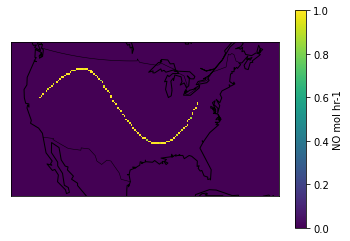

In [17]:
for i in range(1, nt + 3, 3):
  ax = emisncf2.sliceDimensions(TSTEP=slice(0, i)).plot(
      'NO', dimreduction='sum',
      plot_kw=dict(vmin=0, vmax=1),
  )
  display(ax.figure)
  time.sleep(0.5)
  clear_output(wait=True)
  ax.figure.clf()

ax = emisncf2.plot(
    'NO',
    plot_kw=dict(vmin=0, vmax=1),
    dimreduction='sum'
)

# Now Download Output

* You can browse on the left and right-click and download
* Or you can run the code cell below

In [ ]:
files.download(outpath)